In [14]:
from tensorflow import keras
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.applications import vgg19
from keras import Model
import numpy as np
import seaborn as sns
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [15]:
base_img_path = 'landscape.jpeg'
style_reference_path = 'Fernand-Leger-The-City-1919-oil-on-canvas-96.8-x-130.5-cm-38-18-x-51-38-in.jpg'

In [16]:
img_height = 300
img_width = 300

def preprocess(img_path):
    img = keras.utils.load_img(img_path, target_size=(img_height,img_width))
    img = keras.utils.img_to_array(img, dtype='float32')
    img = np.expand_dims(img, 0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess(img):
    img = img.reshape((img_height,img_width, 3))
    img[:,:,0] += 103.939
    img[:,:,1] += 116.779
    img[:,:,2] += 123.68
    img = img[:,:,::-1]
    img = np.clip(img, 0, 255).astype(int)
    return img

First we define a feature extractor that has as inputs VGG19's inputs and as outputs each of VGG19's layers' outputs.

In [17]:
model = vgg19.VGG19(weights='imagenet', include_top=False)
outputs_dict = dict((layer.name, layer.output) for layer in model.layers)

In [18]:
feature_extractor = Model(model.inputs, outputs_dict)

Next we defiine the conttent loss. This simply takes the form of an L2 norm.

In [19]:
def content_loss(base_img, combined_img):
    return tf.reduce_sum(tf.square(combined_img - base_img))

Next the style loss. The style loss is calculated from Gram matrices. If we have some vectors $v_i$, tthen the Gram matrix is defined as $G_{i,j} = v_i \cdot v_j$. If the $v_i$ are the columns of a matrix $X$, then we can define $G = XX^T$.

In the present case, these inner products give information about the style of an image. Thus, we will run the style image and combined image through the model and compare the similarity of the resulting Gram matrices for each.

Below is a simple computation of a Gram matrix.

In [20]:
a = tf.expand_dims(tf.constant([[1,2], [3,4]]), 0)

b = tf.transpose(a, (2,0,1))
b = tf.reshape(b, (tf.shape(b)[0], -1))
print('The "feature map" and its transpose',b, tf.transpose(b))

print('The Gram matrix', tf.matmul(b, tf.transpose(b)))

The "feature map" and its transpose tf.Tensor(
[[1 3]
 [2 4]], shape=(2, 2), dtype=int32) tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)
The Gram matrix tf.Tensor(
[[10 14]
 [14 20]], shape=(2, 2), dtype=int32)


In [21]:
def gram_matrix(x):
    x = tf.transpose(x, (2,0,1))
    x = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(x, tf.transpose(x))
    return gram

def style_loss(style_img, combined_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combined_img)
    channels = 3
    size = img_height*img_width
    loss = tf.reduce_sum(tf.square(S-C))/(4. * (channels**2)*(size**2))
    return loss

Then, there is a regularization term.

In [22]:
def total_variation_loss(x):
    a = tf.square(x[:, :img_height-1, :img_width-1, :] - x[:, 1:, :img_width-1, :])
    b = tf.square(x[:, :img_height-1, :img_width-1, :] - x[:, :img_height-1, 1:, :])
    return tf.reduce_sum(tf.pow(a+b, 1.25))

In [23]:
style_layer_names = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

content_layer_name = 'block5_conv2'

style_weight = 1e-4
content_weight = 2.5e-6
total_variation_weight = 1e-6

In [24]:
def compute_loss(combined_img, base_img, style_img):
    inputs = tf.concat([base_img, style_img, combined_img], axis=0)
    features = feature_extractor(inputs)
    
    loss = tf.zeros(())
    
    # Calculate content loss
    layer_features = features[content_layer_name]
    base_img_features = layer_features[0, :,:,:]
    combination_features = layer_features[2, :,:,:]
    loss = loss + content_weight*content_loss(base_img_features, combination_features)
    
    # Calculate style loss for each style layer
    for name in style_layer_names:
        layer_features = features[name]
        style_features =  layer_features[1, :,:,:]
        combination_features =  layer_features[2, :,:,:]
        
        style_loss_val = style_loss(style_features, combination_features)
        
        loss += (style_weight/len(style_layer_names)) * style_loss_val
    
    # Add total variatoin loss
    loss += total_variation_weight * total_variation_loss(combined_img)
    
    return loss

@tf.function
def compute_loss_and_grads(combined_img, base_img, style_img):
    with tf.GradientTape() as tape:
        loss = compute_loss(combined_img, base_img, style_img)
    grads = tape.gradient(loss, combined_img)
    return loss, grads

Next, set up a learning rate scheduler to exponentially decay the learning rate.

In [25]:
opt = keras.optimizers.Adam(keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=100., decay_steps=100, decay_rate=0.96
))

Finally, generate a new image.

Epoch 5000 || loss 4449.9912109375


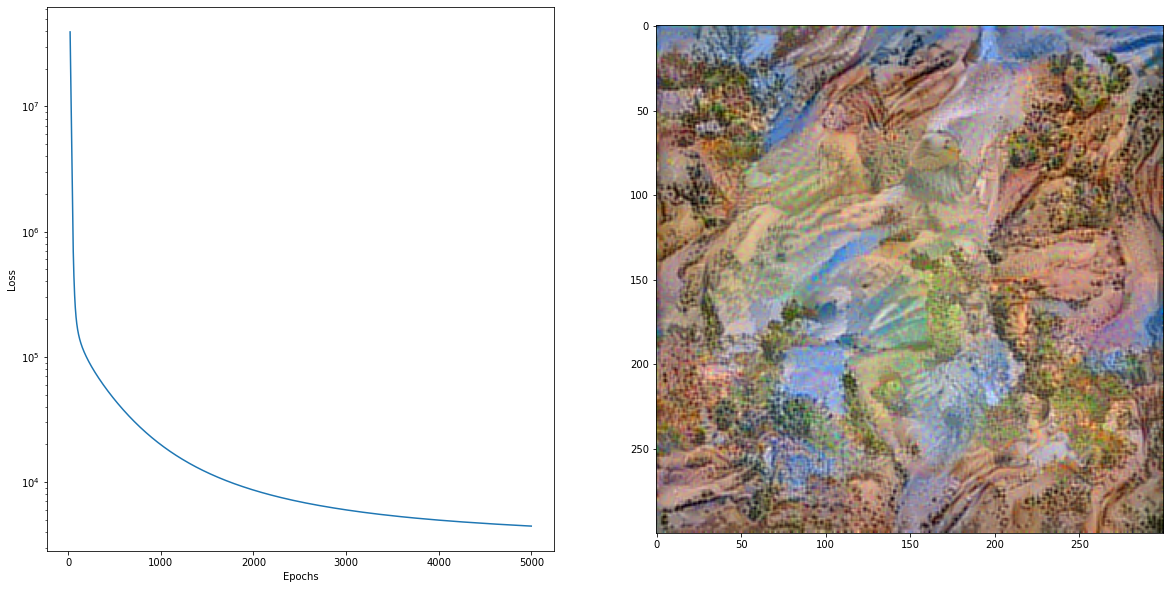

: 

In [26]:
base_img_path = 'eagle.jpg'
style_reference_path = 'miro - wagon tracks.jpg'

base_img = preprocess(base_img_path)
style_img = preprocess(style_reference_path)
combined_img = tf.Variable(preprocess(base_img_path))
losses = []

epochs = 5000
for i in range(1, epochs+1):
    loss, grads = compute_loss_and_grads(combined_img, base_img, style_img)
    opt.apply_gradients([(grads, combined_img)])
    losses.append(loss.numpy())
    
    # Show output every 100 images
    if not i % 10:
        clear_output(wait=True)
        print((f'Epoch {i} || loss {loss}'))
        img = deprocess(combined_img.numpy())
        fname = f'combined_img_iteration_{i}.jpg'
        keras.utils.save_img(fname, img)
        
        if i > 30:
            fig, axes = plt.subplots(1, 2, figsize=(20,10))
            sns.lineplot(x=range(21, i+1), y=losses[20:], ax=axes[0])
            axes[1].imshow(img)
            axes[0].set_xlabel('Epochs')
            axes[0].set_ylabel('Loss')
            axes[0].set_yscale('log')
        else:
            print('The loss and an example will plot after epoch 30')
        plt.show()